In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importation de l'Environnement et des Données


## 1.a librairies

In [2]:
!pip install pyngrok

In [3]:
!pip install mlflow

In [4]:
# Commande pour rétrograder scikit-learn à la version 1.5.2 sur Google Colab
!pip install scikit-learn==1.5.2

# Vérification de la version installée
import sklearn
print("Scikit-learn version:", sklearn.__version__)


Scikit-learn version: 1.5.2


In [5]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import mlflow

# Métriques de classification
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix, auc, classification_report

# Modélisation : Régression Logistique
from sklearn.linear_model import LogisticRegression
# Modélisation : RandomForest
from sklearn.ensemble import RandomForestClassifier
# Modélisation : XGBoost
from sklearn.ensemble import GradientBoostingClassifier
# Modélisation LGBM
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# Feature Engineering
import re
from collections import Counter

# Preprocessing et standardisation

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Séparation du jeu de données
from sklearn.model_selection import train_test_split

# Modélisation
# Régression Logistique
from sklearn.linear_model import LogisticRegression

# Dummy Classifier
from sklearn.dummy import DummyClassifier

# XGBoost
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

# Modélisation LGBM
from lightgbm import LGBMClassifier

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter # counter takes values returns value_counts dictionary
from sklearn.datasets import make_classification

# Optimisation du modèle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_row', 200)
pd.set_option('display.max_colwidth', 200)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 1.b Données

In [6]:
# Définir le path pour les fichiers
path='/content/drive/My Drive/Projets Master/Projet 7/X_test_x_train/'
# Importer X_train_join6 et X_test_join6 depuis le path
X_train = pd.read_csv(path + 'X_train_feautres.csv')
X_test = pd.read_csv(path + 'X_test_feautres.csv')
y = pd.read_csv(path + 'y.csv')
y_1= pd.read_csv(path + 'y.csv')

df=pd.read_csv(path + 'df.csv')
# Afficher les dimensions pour vérifier l'importation
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y shape:", y.shape)
print("df shape:", df.shape)

X_train shape: (307511, 23)
X_test shape: (48744, 23)
y shape: (307511, 1)
df shape: (307511, 24)


In [7]:
# Création d'un jeu de données pour l'étape du Dashboard
import random
path_dashboard = '/content/drive/My Drive/Projets Master/Projet 7/X_test_x_train/df_dashboard.csv'
path_knn = '/content/drive/My Drive/Projets Master/Projet 7/X_test_x_train/df_dash_KNN.csv'

# Sélection aléatoire de 100 clients
random_clients = random.sample(list(df['SK_ID_CURR']), k=100)

# Création du nouveau DataFrame df_dashboard avec les clients sélectionnés
df_dashboard = df[df['SK_ID_CURR'].isin(random_clients)].copy()
df_dashboard.to_csv(path_knn, index =False)

# Suppression de la variable 'TARGET' dans le nouveau DataFrame
df_dashboard.drop('TARGET', axis=1, inplace=True)

# Enregistrement du DataFrame df_dashboard dans un fichier CSV
df_dashboard.to_csv(path_dashboard, index=False)
df_dashboard.shape


(100, 23)

## Fonctions Utiles a notre etude

**Définition des métriques d'évaluation**

**1. Accuracy Score**
L'accuracy mesure le pourcentage de prédictions correctes parmi toutes les prédictions effectuées.  
**Formule** :  
\[ \text{Accuracy} = \frac{\text{Nombre de prédictions correctes}}{\text{Nombre total de prédictions}} \]  
**Limite** : Peu pertinente dans le cas d’un déséquilibre des classes, car une forte classe majoritaire peut fausser l’évaluation.

---

**2. Precision Score**
La précision mesure la proportion de prédictions positives correctes parmi toutes les prédictions positives effectuées.  
**Formule** :  
\[ \text{Precision} = \frac{\text{Vrai Positifs (TP)}}{\text{Vrai Positifs (TP)} + \text{Faux Positifs (FP)}} \]  
**Interprétation** : Utile pour évaluer la précision des prédictions positives, mais peut négliger les faux négatifs.

---

 **3. Recall Score**
Le rappel mesure la capacité du modèle à identifier correctement les échantillons positifs (classe minoritaire).  
**Formule** :  
\[ \text{Recall} = \frac{\text{Vrai Positifs (TP)}}{\text{Vrai Positifs (TP)} + \text{Faux Négatifs (FN)}} \]  
**Interprétation** : Important pour détecter la classe minoritaire (les clients en défaut de paiement). Un faible rappel indique que de nombreux défauts sont manqués.

---

**4. F1 Score**
Le F1 score est une moyenne harmonique entre la précision et le rappel, donnant un équilibre entre les deux.  
**Formule** :  
\[ \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \]  
**Interprétation** : Utile pour les datasets déséquilibrés, car il prend en compte à la fois les faux positifs et les faux négatifs.

---

**5. F2 Score**
Le F2 score est une variante du F1 score qui donne plus de poids au rappel qu’à la précision.  
**Formule** :  
\[ \text{F2} = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{\beta^2 \cdot \text{Precision} + \text{Recall}}, \text{avec } \beta = 2 \]  
**Interprétation** : Favorise les modèles qui minimisent les faux négatifs, ce qui peut être crucial pour identifier les clients à risque.

---

**6. ROCAUC Score (Receiver Operating Characteristic - Area Under Curve)**
Le score ROCAUC mesure la performance globale d'un modèle sur toutes les classes en évaluant le taux de vrais positifs (TPR) et le taux de faux positifs (FPR).  
**Interprétation** : Un score proche de 1 indique un modèle performant. Particulièrement utile pour comparer différents modèles.

---

**7. Custom Metric - FMI (Fowlkes-Mallows Index)**
Le Fowlkes-Mallows Index est une métrique qui combine la précision et le rappel pour mesurer la qualité des clusters ou des prédictions.  
**Formule** :  
\[ \text{FMI} = \sqrt{\frac{\text{Precision} \cdot \text{Recall}}{\text{(Precision + Recall)}}} \]  
**Interprétation** : Évalue la balance entre précision et rappel, tout en prenant en compte leur relation.

---

**Quelle est la métrique la plus importante ?**
Dans le cadre de notre problématique, **le rappel (recall)** est probablement la métrique la plus importante. Identifier correctement les clients à risque (classe minoritaire) est crucial pour réduire les pertes potentielles liées aux défauts de paiement. Un modèle avec un bon rappel minimise les **faux négatifs**, c'est-à-dire les cas où un client à risque est mal classé comme non-défaillant.

Cependant, les autres métriques (F1, F2 et ROCAUC) peuvent également être pertinentes pour avoir une vue d’ensemble des performances du modèle.


**La Matrice de Confusion en Classification**

Dans la tâche de classification, la **matrice de confusion** est un outil fondamental pour évaluer la qualité d'un modèle. Elle représente un tableau à double entrée qui met en correspondance les **classes réelles** et les **classes prédites** par le modèle. Chaque case du tableau contient le nombre d'échantillons correspondant à une combinaison spécifique de classe réelle et prédite.

**Structure de la matrice de confusion (binaire) :**

|               | **Classe prédite : Positive** | **Classe prédite : Négative** |
|---------------|-------------------------------|-------------------------------|
| **Classe réelle : Positive** | **Vrais Positifs (TP)**            | **Faux Négatifs (FN)**            |
| **Classe réelle : Négative** | **Faux Positifs (FP)**             | **Vrais Négatifs (TN)**            |

- **Vrais Positifs (TP)** : Nombre de cas où le modèle a correctement prédit la classe positive.
- **Faux Négatifs (FN)** : Nombre de cas où le modèle a prédit la classe négative alors qu'elle est positive (erreurs graves pour la classe minoritaire).
- **Faux Positifs (FP)** : Nombre de cas où le modèle a prédit la classe positive alors qu'elle est négative.
- **Vrais Négatifs (TN)** : Nombre de cas où le modèle a correctement prédit la classe négative.

---

**Interprétation :**
- **Vrais Positifs (TP)** : Cas où le modèle identifie correctement les instances positives.
- **Faux Négatifs (FN)** : Cas critiques où des instances positives (par exemple, clients en défaut) sont mal classées.
- **Faux Positifs (FP)** : Cas où le modèle évalue à tort des instances négatives comme positives.
- **Vrais Négatifs (TN)** : Cas où le modèle évalue correctement des instances négatives.

---

**Pourquoi est-ce important ?**
La matrice de confusion permet :
1. **D’identifier les forces et les faiblesses d’un modèle** : On peut facilement visualiser si le modèle tend à surclasser une classe ou à manquer des instances positives.
2. **De calculer des métriques importantes** comme le rappel, la précision, l'accuracy et le F1-score. Ces métriques sont basées directement sur les valeurs de la matrice de confusion.
3. **D'adapter les décisions métiers** : Par exemple, dans notre cas, minimiser les faux négatifs (clients à risque mal identifiés) est crucial.

---

**Utilité dans notre contexte**
Dans la tâche de prédiction du risque de défaut d’un client, la matrice de confusion est essentielle pour comprendre si le modèle :
- Identifie correctement les clients à risque (minimisation des faux négatifs).
- Réduit les fausses alertes (minimisation des faux positifs) qui pourraient surcharger les équipes de gestion.


In [8]:
# Création de la fonction personnalisée

def custom_metric(y, y_pred):
    TP = np.sum( (y==1) & (y_pred==1) )
    FP = np.sum( (y==0) & (y_pred==1) )
    TN = np.sum( (y==0) & (y_pred==0) )
    FN = np.sum( (y==1) & (y_pred==0) )
    PPV = TP / (TP + FP)
    TPR = TP / (TP + FN)
    FMI = np.sqrt( PPV * TPR )
    return FMI

def custom_metric_f2(y, y_pred):

    return fbeta_score(y, y_pred,2)

custom_scorer = make_scorer(custom_metric, greater_is_better=True )
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True )

In [9]:
def model_eval_score(model, Xval, yval):
    y_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, y_pred)
    print(conf_mat)
    print(f'Accuracy score    : {accuracy_score(yval, y_pred):.3}')
    print(f'precision score   : {precision_score(yval, y_pred):.3}')
    print(f'recall score      : {recall_score(yval, y_pred):.3}')
    print(f'F1 score          : {f1_score(yval, y_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, y_pred, beta=2):.2}')
    print(f'ROCAUC score      : {roc_auc_score(yval, y_pred):.3}')
    print(f'custom metric FMI : {custom_metric(yval, y_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)

    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Modelisation  

## Standardisation et seperation du jeu de données

In [10]:
# Création du train_test_split

# Séparation des données de la cible
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Division en train et validation (75/25)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=100)

display('Données entrainements : ',X_train.shape, X_val.shape)
display('Données de validation',y_train.shape, y_val.shape)

'Données entrainements : '

(230633, 23)

(76878, 23)

'Données de validation'

(230633,)

(76878,)

In [11]:
import pandas as pd

# Création des DataFrames pour les données d'entraînement et de validation
train_data = pd.DataFrame(X_train)
test_data = pd.DataFrame(X_val)

path_train_data = '/content/drive/My Drive/Projets Master/Projet 7/Application_train_test/application_train.csv'
path_test_data = '/content/drive/My Drive/Projets Master/Projet 7/Application_train_test/application_test.csv'

# Enregistrement des données d'entraînement dans un fichier CSV
train_data.to_csv(path_train_data, index=False)

# Enregistrement des données de validation dans un fichier CSV
test_data.to_csv(path_test_data, index=False)

print("Les fichiers 'application_train.csv' et 'application_test.csv' ont été créés avec succès.")

Les fichiers 'application_train.csv' et 'application_test.csv' ont été créés avec succès.


In [12]:
# Créer un objet StandardScaler
scaler = StandardScaler()

# Adapter et transformer les données d'entraînement
X_train_stand = scaler.fit_transform(X_train)

# Transformer les données de test
X_val_stand = scaler.transform(X_val)

In [13]:
# Créer un objet MinMaxScaler
scaler = MinMaxScaler()

# Adapter et transformer les données d'entraînement
X_train_scaled = scaler.fit_transform(X_train)

# Transformer les données de validation
X_val_scaled = scaler.transform(X_val)

In [14]:
# Transformation des matrices standardisées en dataframe pour avoir les noms des variables

X_train_sd_df = pd.DataFrame(X_train, columns=list(X_train))
X_valid_sd_df = pd.DataFrame(X_val, columns=list(X_train))
y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)

In [15]:
X_valid_sd_df.head(5)

,SK_ID_CURR,EXT_SOURCE_2,taille_famille,anciennete_entreprise,age_client,taux_endettement,total_revenus,montant_credit,nb_demande_pret_precedente,montant_demande_pret_precedente,heure_demande_pret_precedente,nb_year_depuis_decision_precedente,prev_contrat_type_consumer_loans,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,montant_paye_vs_du,days_past_due,DAYS_CREDIT,AMT_CREDIT_SUM,bureau_credit_actif_Closed,bureau_credit_type_Credit_card,solde_credit_bureau_statut_closed,CNT_INSTALMENT
226323,362145,0.612737,1,1,2,4,1,4,1.0,50332.500,11.000000,4.00,1.0,1.0,15.0,100.000000,0.000000,4.250000,225333.00,3.0,2.0,0.0,5.000000
216456,350807,0.468026,0,0,4,2,0,2,12.0,169255.875,9.166667,1.75,2.0,2.0,373.0,94.548508,0.054545,0.000000,0.00,0.0,0.0,0.0,13.267857
36242,141967,0.228625,1,4,2,4,0,4,2.0,60520.500,12.000000,3.50,2.0,1.0,76.0,100.000000,0.000000,3.375000,791001.00,6.0,1.0,0.0,8.444444
227057,362998,0.731057,1,0,4,4,1,4,2.0,81202.500,11.000000,1.00,1.0,1.0,28.0,100.000000,0.142857,2.000000,64885.05,1.0,1.0,0.0,12.000000
100973,217238,0.696589,2,4,2,1,3,1,1.0,64660.500,17.000000,4.00,1.0,1.0,21.0,100.000000,0.000000,3.714286,348642.00,6.0,2.0,0.0,6.000000


## Creation de notre MlFLOW pour le suivi des modeles

In [16]:
# Convertir y_train en array NumPy
y_train = np.array(y_train)

In [92]:
import subprocess
subprocess.Popen(['mlflow','ui','--backend-store-uri','file:///content/drive/My Drive/Projets Master/Projet 7/mlruns'])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'file...>

In [93]:
import mlflow

# Définir le répertoire pour stocker les données de MLflow
mlflow.set_tracking_uri('file:///content/drive/My Drive/Projets Master/Projet 7/mlruns')

# Création du MLFLOW
mlflow.set_experiment('Modélisation Projet7 ')

<Experiment: artifact_location=('file:///content/drive/My Drive/Projets Master/Projet '
 '7/mlruns/721009055439463447'), creation_time=1736172939896, experiment_id='721009055439463447', last_update_time=1736172939896, lifecycle_stage='active', name='Modélisation Projet7 ', tags={}>

In [94]:
import getpass
from pyngrok import ngrok
from pyngrok import conf
conf.get_default().auth_token = getpass.getpass('Enter the auth token from ngrok')
port=5000
public_url = ngrok.connect(port).public_url
print(f'* ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')


Enter the auth token from ngrok··········
* ngrok tunnel "https://456c-34-73-75-177.ngrok-free.app" -> "http://127.0.0.1:5000"


In [20]:
# Création du MLFLOW

mlflow.set_experiment('Modélisation Projet7 ')

mlflow.sklearn.autolog()

## 1. Régression Logistique


[[70601     4]
 [ 6269     4]]
Accuracy score    : 0.918
precision score   : 0.5
recall score      : 0.000638
F1 score          : 0.00127
F2 score          : 0.0008
ROCAUC score      : 0.5
custom metric FMI : 0.0179



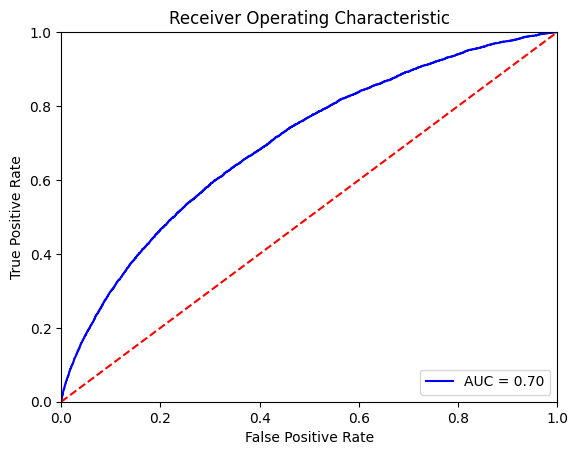

In [21]:
# Régression Logistique avec StandardScaler
logreg = LogisticRegression()


# Second run du mlflow
with mlflow.start_run(run_name = 'Reglog StandardScaler'):
    logreg = LogisticRegression()
    logreg.fit(X_train_stand, y_train)

# Prédiction sur l'ensemble de validation
y_pred = logreg.predict(X_val_stand)

model_eval(logreg, X_val_stand, y_val)

## 2. Dummy Classifier


[[64903  5702]
 [ 5757   516]]
Accuracy score    : 0.851
precision score   : 0.083
recall score      : 0.0823
F1 score          : 0.0826
F2 score          : 0.082
ROCAUC score      : 0.501
custom metric FMI : 0.0826



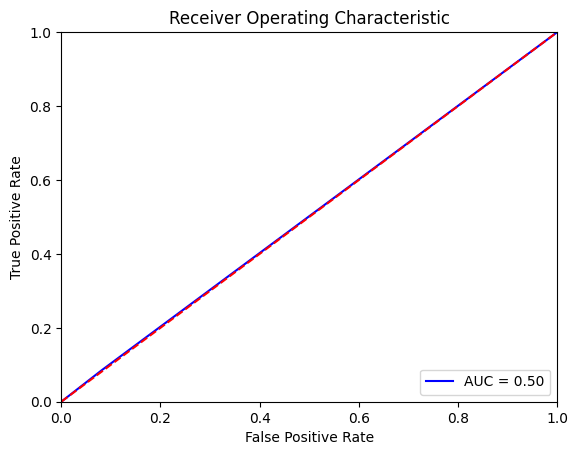

In [22]:
# DummyClassifier avec StandardScaler


# Instancier le DummyClassifier
with mlflow.start_run(run_name = 'Dummy StandardScaler'):
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_train_stand, y_train)


# Prédire les étiquettes de classe pour les données de test
y_pred = dummy_clf.predict(X_val_stand)

model_eval(dummy_clf, X_val_stand, y_val)

[[64937  5668]
 [ 5779   494]]
Accuracy score    : 0.851
precision score   : 0.0802
recall score      : 0.0788
F1 score          : 0.0795
F2 score          : 0.079
ROCAUC score      : 0.499
custom metric FMI : 0.0795



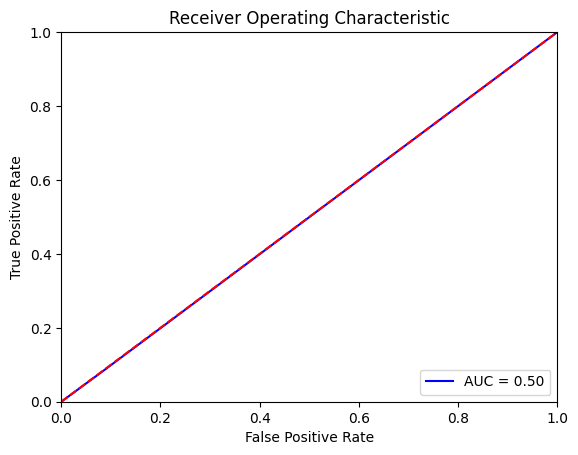

In [23]:
# DummyClassifier avec MinMaxScaler


# Instancier le DummyClassifier en utilisant la stratégie stratified
with mlflow.start_run(run_name = 'Dummy MinMaxScaler'):
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_train_scaled, y_train)


# Prédire les étiquettes de classe pour les données de test
y_pred = dummy_clf.predict(X_val_scaled)

model_eval(dummy_clf, X_val_scaled, y_val)

## 3. XGBoost


[[70456   149]
 [ 6161   112]]
Accuracy score    : 0.918
precision score   : 0.429
recall score      : 0.0179
F1 score          : 0.0343
F2 score          : 0.022
ROCAUC score      : 0.508
custom metric FMI : 0.0875



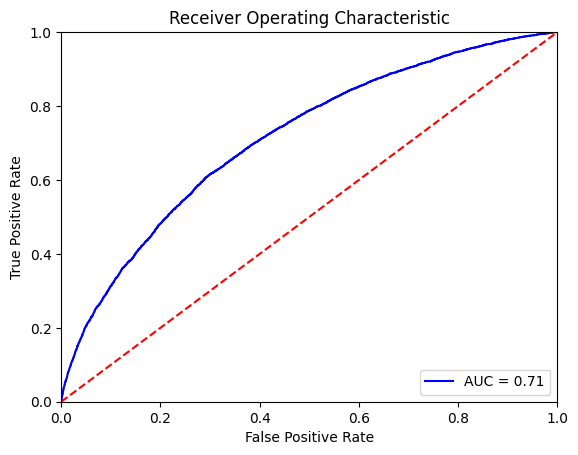

In [24]:
# XGBoost avec StandardScaler


# Création du modèle avec XGBoost
xgboost =xgb.XGBClassifier()

# Second run du mlflow
with mlflow.start_run(run_name = 'XGBoost StandardScaler'):
    xgboost =xgb.XGBClassifier()
    xgboost.fit(X_train_stand, y_train)


# Prédiction sur l'ensemble de validation
y_pred = xgboost.predict(X_val_stand)

model_eval(xgboost, X_val_stand, y_val)

[[70456   149]
 [ 6161   112]]
Accuracy score    : 0.918
precision score   : 0.429
recall score      : 0.0179
F1 score          : 0.0343
F2 score          : 0.022
ROCAUC score      : 0.508
custom metric FMI : 0.0875



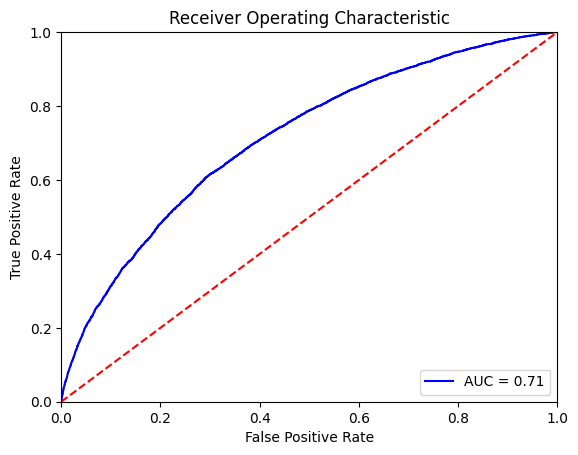

In [25]:
# XGBoost avec MinMaxScaler

# Création du modèle avec XGBoost
xgboost =xgb.XGBClassifier()

# 3ème run du mlflow
with mlflow.start_run(run_name = 'XGBoost MinMaxScaler'):
    xgboost =xgb.XGBClassifier()
    xgboost.fit(X_train_scaled, y_train)



# Prédiction sur l'ensemble de validation
y_pred = xgboost.predict(X_val_scaled)

model_eval(xgboost, X_val_scaled, y_val)

## 4. Random Forest


[[70596     9]
 [ 6265     8]]
Accuracy score    : 0.918
precision score   : 0.471
recall score      : 0.00128
F1 score          : 0.00254
F2 score          : 0.0016
ROCAUC score      : 0.501
custom metric FMI : 0.0245



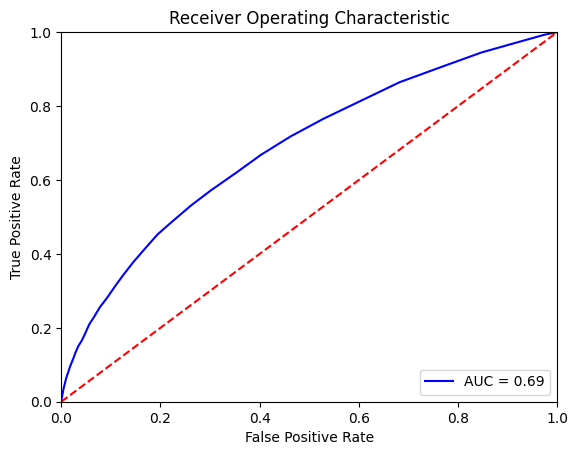

In [26]:
# RandomForest avec StandardScaler

randor = RandomForestClassifier()

# Second run du mlflow
with mlflow.start_run(run_name = 'Forest StandardScaler'):
    logreg = LogisticRegression()
    randor.fit(X_train_stand, y_train)


# Prédiction sur l'ensemble de validation
y_pred = randor.predict(X_val_stand)

model_eval(randor, X_val_stand, y_val)

[[70595    10]
 [ 6263    10]]
Accuracy score    : 0.918
precision score   : 0.5
recall score      : 0.00159
F1 score          : 0.00318
F2 score          : 0.002
ROCAUC score      : 0.501
custom metric FMI : 0.0282



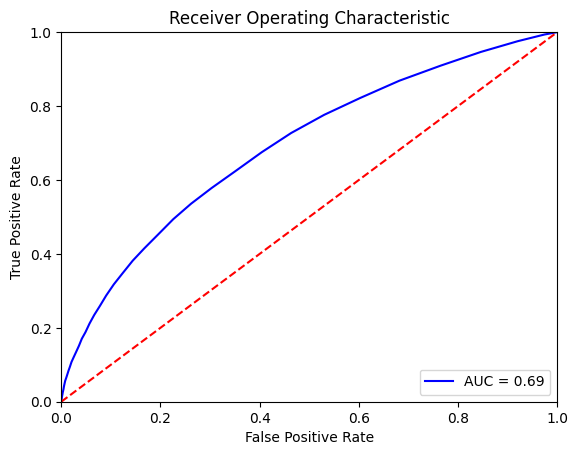

In [27]:
# RandomForest avec MinMaxScaler

randor = RandomForestClassifier()

# 3ème run du mlflow
with mlflow.start_run(run_name = 'Forest MinMaxScaler'):
    logreg = LogisticRegression()
    randor.fit(X_train_scaled, y_train)


# Prédiction sur l'ensemble de validation
y_pred = randor.predict(X_val_scaled)

model_eval(randor, X_val_scaled, y_val)

## 5. LightGBM


[LightGBM] [Info] Number of positive: 18552, number of negative: 212081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080439 -> initscore=-2.436391
[LightGBM] [Info] Start training from score -2.436391
[[70577    28]
 [ 6235    38]]
Accuracy score    : 0.919
precision score   : 0.576
recall score      : 0.00606
F1 score          : 0.012
F2 score          : 0.0076
ROCAUC score      : 0.503
custom metric FMI : 0.0591



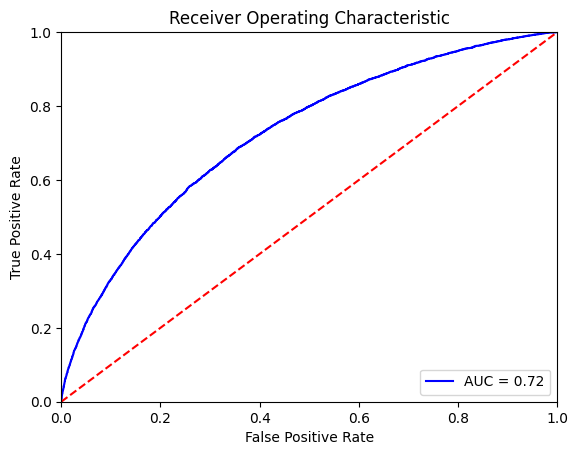

In [28]:
# LIGHTGBM avec StandardScaled

# Création de la pipeline
lightgbm = LGBMClassifier()

# 2nd run
with mlflow.start_run(run_name = 'LightGBM StandardScaler'):
    lightgbm = LGBMClassifier()
    lightgbm.fit(X_train_stand, y_train,
                eval_metric= custom_metric_f2)



# Prédiction sur l'ensemble de validation
y_pred = lightgbm.predict(X_val_stand)

model_eval(lightgbm, X_val_stand, y_val)

[LightGBM] [Info] Number of positive: 18552, number of negative: 212081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3196
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080439 -> initscore=-2.436391
[LightGBM] [Info] Start training from score -2.436391
[[70576    29]
 [ 6236    37]]
Accuracy score    : 0.919
precision score   : 0.561
recall score      : 0.0059
F1 score          : 0.0117
F2 score          : 0.0074
ROCAUC score      : 0.503
custom metric FMI : 0.0575



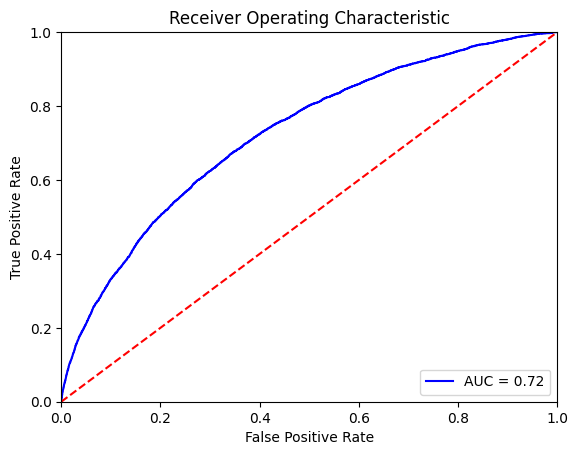

In [29]:
# LIGHTGBM avec MinMaxScaler

# Création de la pipeline
lightgbm = LGBMClassifier()

# 3nd run
with mlflow.start_run(run_name = 'LightGBM MinMaxScaler'):
    lightgbm = LGBMClassifier()
    lightgbm.fit(X_train_scaled, y_train,
                eval_metric= custom_metric_f2)



# Prédiction sur l'ensemble de validation
y_pred = lightgbm.predict(X_val_scaled)

model_eval(lightgbm, X_val_scaled, y_val)

# Gestion du desequilibre de classe

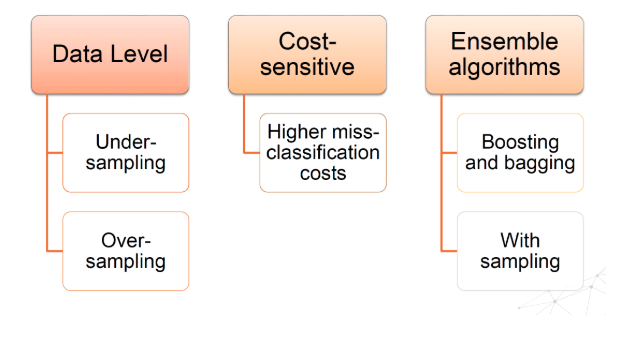

In [30]:
!pip install xplotter

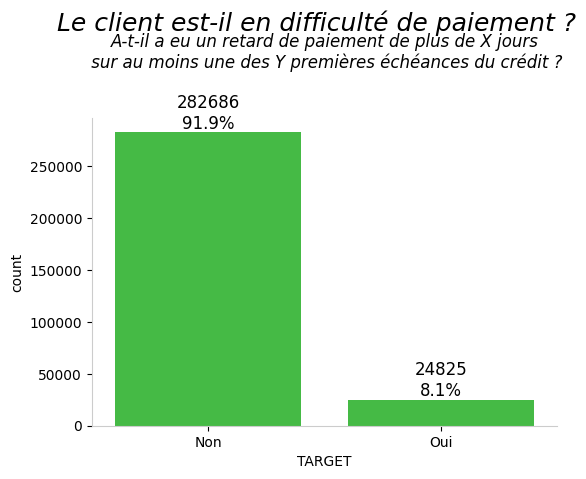

In [31]:
from xplotter.insights import *

colors = ['#32CD32']  # Couleur verte en hexadécimal

loan_map = {1 : "Oui",
            0 : "Non"}

fig, ax = plt.subplots(figsize=(6, 4))

plot_countplot(df=y_1,
               col='TARGET',
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)

plt.suptitle("Le client est-il en difficulté de paiement ?\n",
             y=1.15, fontsize=18, fontstyle='italic')
plt.title("A-t-il a eu un retard de paiement de plus de X jours\n sur au moins une des Y premières échéances du crédit ?\n\n",
           loc="center", fontsize=12, fontstyle='italic')
plt.show()

In [32]:
print(f"imbalance_ratio = {24825 / 282686:.2%}")


imbalance_ratio = 8.78%


In [33]:
print("y_train_series - TARGET")
print(pd.DataFrame({
    "COUNT": y_train_df.value_counts(),
    "RATIO": y_train_df.value_counts() / len(y_train_df) * 100}))

y_train_series - TARGET
         COUNT      RATIO
TARGET                   
0       212081  91.956051
1        18552   8.043949


In [34]:
print("y_valid_series - TARGET")
print(pd.DataFrame({
    "COUNT": y_valid_df.value_counts(),
    "RATIO": y_valid_df.value_counts() / len(y_valid_df) * 100}))

y_valid_series - TARGET
        COUNT      RATIO
TARGET                  
0       70605  91.840318
1        6273   8.159682


## 1. RandomOverSample

**Oversampling**
L’**oversampling** consiste à augmenter artificiellement le nombre d’exemples dans la classe minoritaire en répliquant ou en générant de nouveaux exemples. Cela permet de rééquilibrer le dataset.  
**Avantages** :
- Aucune perte d’information de la classe majoritaire.
- Utile pour conserver une taille de dataset importante.  
**Inconvénients** :
- Risque de surajustement, car les exemples ajoutés peuvent être très similaires aux existants.
- Peut augmenter le temps d’entraînement

In [35]:
over = RandomOverSampler(random_state=100)

# fit and apply the transform
X_over, y_over = over.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_over))

Counter({0: 212081, 1: 18552})
Counter({0: 212081, 1: 212081})


### Régression Logistique


2025/01/06 19:16:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '01668dfe564c44ef949e3d715f71b54c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[46585 24020]
 [ 2335  3938]]
Accuracy score    : 0.657
precision score   : 0.141
recall score      : 0.628
F1 score          : 0.23
F2 score          : 0.37
ROCAUC score      : 0.644
custom metric FMI : 0.297



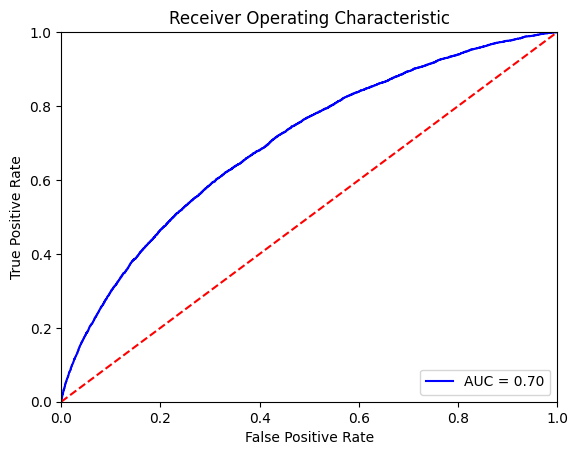

In [36]:
logis_over = LogisticRegression()
logis_over.fit(X_over, y_over)

reglog_under_ros = logis_over.predict(X_val_stand)

model_eval(logis_over, X_val_stand, y_val)

### Dummy Classifier


2025/01/06 19:16:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'de2453907ea44d0787ac45c3cf95585f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[35159 35446]
 [ 3180  3093]]
Accuracy score    : 0.498
precision score   : 0.0803
recall score      : 0.493
F1 score          : 0.138
F2 score          : 0.24
ROCAUC score      : 0.496
custom metric FMI : 0.199



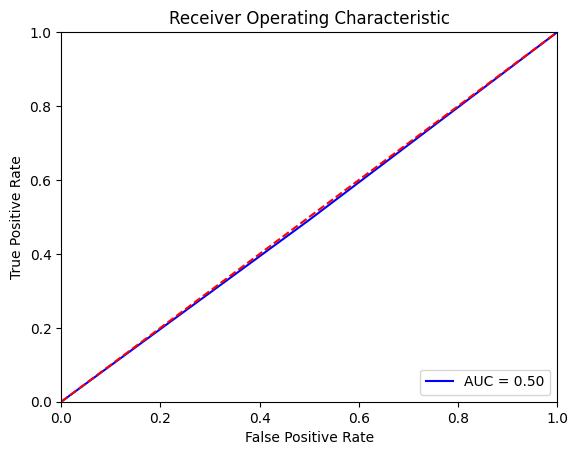

In [37]:

dummy_over = DummyClassifier(strategy="stratified")
dummy_over.fit(X_over, y_over)

dummy_under_ros = dummy_over.predict(X_val_stand)

model_eval(dummy_over, X_val_stand, y_val)

### Random Forest


2025/01/06 19:17:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'deddd6b99e5f4193a7331e997c6cabab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[70525    80]
 [ 6230    43]]
Accuracy score    : 0.918
precision score   : 0.35
recall score      : 0.00685
F1 score          : 0.0134
F2 score          : 0.0085
ROCAUC score      : 0.503
custom metric FMI : 0.049



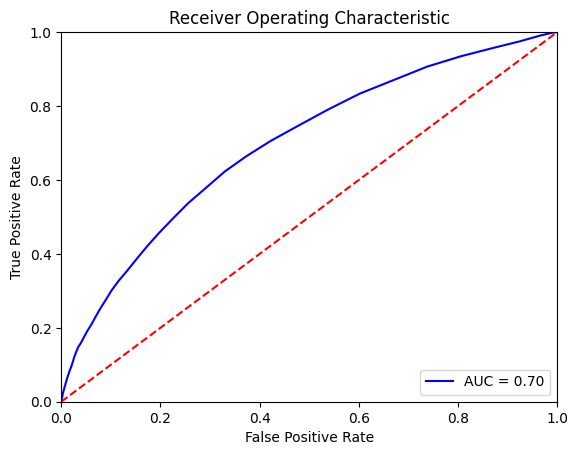

In [38]:
random_over = RandomForestClassifier()
random_over.fit(X_over, y_over)

random_under_ros = random_over.predict(X_val_stand)

model_eval(random_over, X_val_stand, y_val)

### XGBoost


[[51606 18999]
 [ 2748  3525]]
Accuracy score    : 0.717
precision score   : 0.156
recall score      : 0.562
F1 score          : 0.245
F2 score          : 0.37
ROCAUC score      : 0.646
custom metric FMI : 0.297



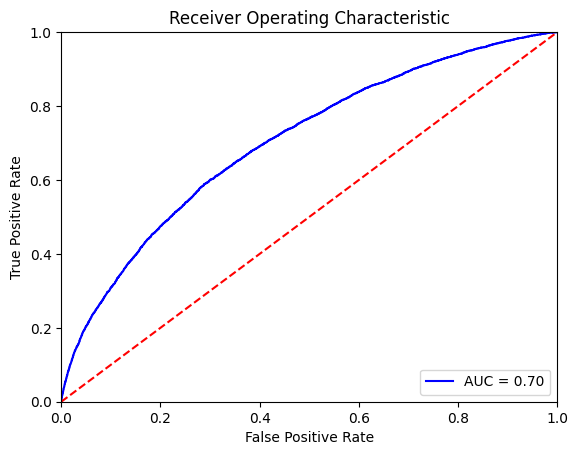

In [39]:
xgboost_over = xgb.XGBClassifier()
xgboost_over.fit(X_over, y_over)

xgboost_under_ros = xgboost_over.predict(X_val_stand)

model_eval(xgboost_over, X_val_stand, y_val)

### LIGHTGBM

[LightGBM] [Info] Number of positive: 212081, number of negative: 212081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 424162, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[48699 21906]
 [ 2274  3999]]
Accuracy score    : 0.685
precision score   : 0.154
recall score      : 0.637
F1 score          : 0.249
F2 score          : 0.39
ROCAUC score      : 0.664
custom metric FMI : 0.314



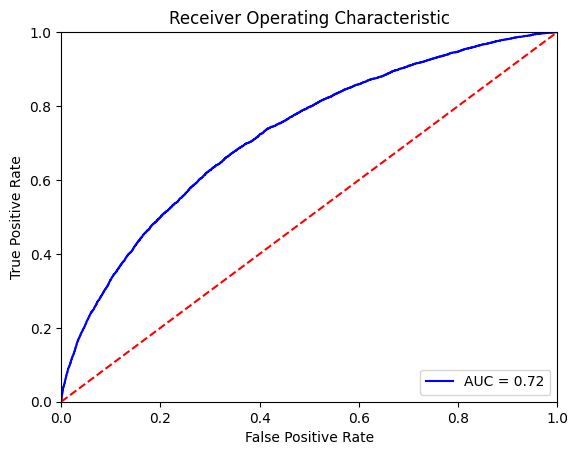

In [40]:
light_over = LGBMClassifier()
light_over.fit(X_over, y_over)

light_under_ros = light_over.predict(X_val_stand)

model_eval(light_over, X_val_stand, y_val)

## 2. RandomUnderSample


**Undersampling**


L’**undersampling** consiste à réduire la taille de la classe majoritaire pour équilibrer le dataset. Cette méthode élimine aléatoirement des exemples de la classe dominante afin d’obtenir une distribution équilibrée.  
**Avantages** :
- Réduit le temps d’entraînement.
- Utile lorsque les données sont nombreuses.  
**Inconvénients** :
- Risque de perdre des informations importantes en supprimant des données pertinentes.
- Peut conduire à un surajustement sur les données restantes.


In [41]:
# Création des déséquilibres

under = RandomUnderSampler(random_state=100)

# fit and apply the transform
X_under, y_under = under.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_under))

Counter({0: 212081, 1: 18552})
Counter({0: 18552, 1: 18552})


In [42]:
logis_under = LogisticRegression()
logis_under.fit(X_under, y_under)


2025/01/06 19:22:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bc62c887980347b0a480cecaaab41edb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LogisticRegression()

### Dummy Classifier


2025/01/06 19:22:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e20037c35cd34677b69d0f23ade4e0eb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[35445 35160]
 [ 3184  3089]]
Accuracy score    : 0.501
precision score   : 0.0808
recall score      : 0.492
F1 score          : 0.139
F2 score          : 0.24
ROCAUC score      : 0.497
custom metric FMI : 0.199



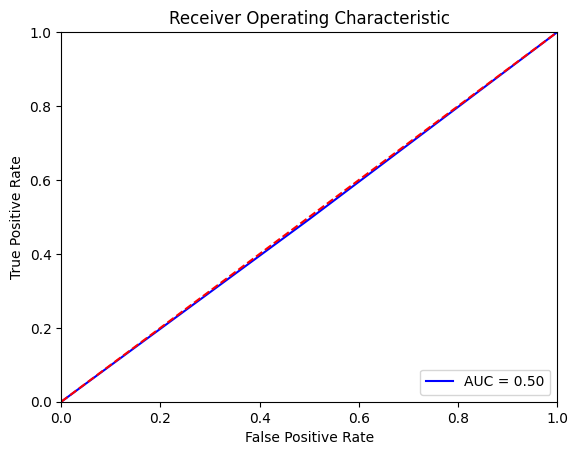

In [43]:
dummy_under = DummyClassifier(strategy="stratified")
dummy_under.fit(X_under, y_under)


dummy_under_rus = logis_under.predict(X_val_stand)

model_eval(dummy_under, X_val_stand, y_val)

### Random forest

2025/01/06 19:23:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bdb6a461a5d54353b94e52f710c97024', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[47312 23293]
 [ 2295  3978]]
Accuracy score    : 0.667
precision score   : 0.146
recall score      : 0.634
F1 score          : 0.237
F2 score          : 0.38
ROCAUC score      : 0.652
custom metric FMI : 0.304



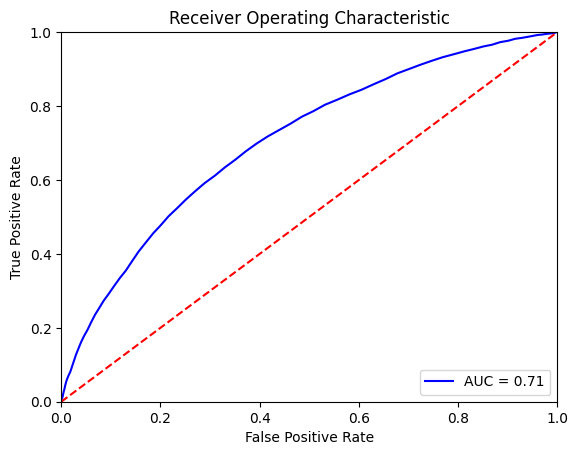

In [44]:
random_under = RandomForestClassifier()
random_under.fit(X_under, y_under)

random_under_rus = random_under.predict(X_val_stand)

model_eval(random_under, X_val_stand, y_val)

### Régression Logistique


[[46771 23834]
 [ 2353  3920]]
Accuracy score    : 0.659
precision score   : 0.141
recall score      : 0.625
F1 score          : 0.23
F2 score          : 0.37
ROCAUC score      : 0.644
custom metric FMI : 0.297



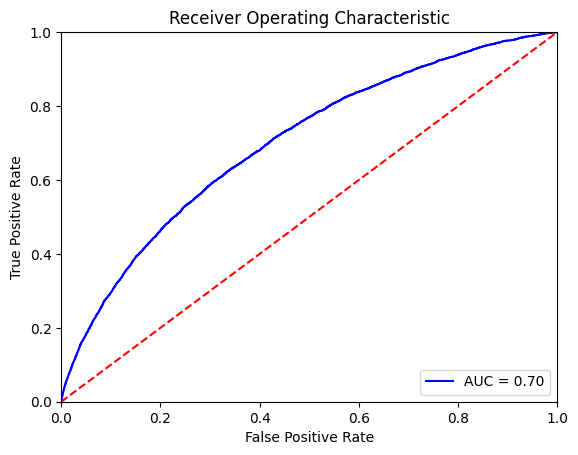

In [45]:
log_under_rus = logis_under.predict(X_val_stand)
model_eval(logis_under, X_val_stand, y_val)

### XgBoost

[[45952 24653]
 [ 2229  4044]]
Accuracy score    : 0.65
precision score   : 0.141
recall score      : 0.645
F1 score          : 0.231
F2 score          : 0.38
ROCAUC score      : 0.648
custom metric FMI : 0.301



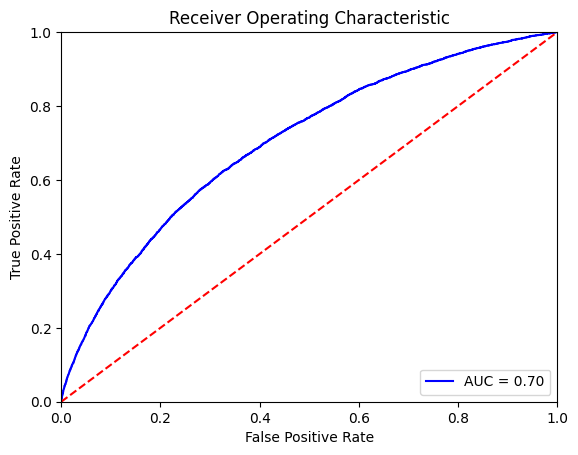

In [46]:
xgboost_under = xgb.XGBClassifier()
xgboost_under.fit(X_under, y_under)

xgboost_under_rus = xgboost_under.predict(X_val_stand)

model_eval(xgboost_under, X_val_stand, y_val)

### LightGBM

[LightGBM] [Info] Number of positive: 18552, number of negative: 18552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 37104, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[46973 23632]
 [ 2166  4107]]
Accuracy score    : 0.664
precision score   : 0.148
recall score      : 0.655
F1 score          : 0.242
F2 score          : 0.39
ROCAUC score      : 0.66
custom metric FMI : 0.311



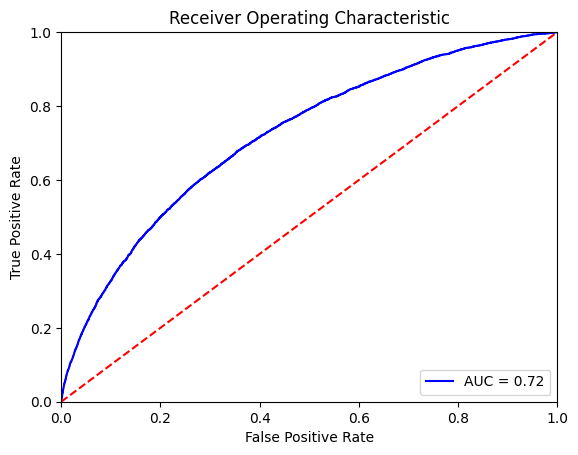

In [47]:
light_under = LGBMClassifier()
light_under.fit(X_under, y_under)

light_under_rus = light_under.predict(X_val_stand)

model_eval(light_under, X_val_stand, y_val)

## 3. Smote


 **SMOTE (Synthetic Minority Oversampling Technique)**
Le **SMOTE** est une méthode avancée d’oversampling qui génère de nouveaux exemples synthétiques dans la classe minoritaire au lieu de simplement dupliquer les exemples existants. Il crée ces nouveaux points en interpolant entre les exemples existants.  
**Avantages** :
- Réduit le risque de surajustement associé à un oversampling classique.
- Crée de la diversité dans la classe minoritaire.  
**Inconvénients** :
- Peut générer des points moins représentatifs dans des zones où la classe minoritaire est déjà mal représentée.
- Peut introduire du bruit dans les données.


In [48]:
smote = SMOTE(random_state=100)

# fit and apply the transform
X_smote, y_smote = smote.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_smote))

2025/01/06 19:23:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '63a7a8824fb342af82e09705f73509b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:23:54 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/01/06 19:23:54 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/01/06 19:23:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/01/06 19:23:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signatu

Counter({0: 212081, 1: 18552})
Counter({0: 212081, 1: 212081})


### Régression Logistique


2025/01/06 19:24:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '11a969ecdb274ba88ce558a37ebeb4da', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[46617 23988]
 [ 2334  3939]]
Accuracy score    : 0.658
precision score   : 0.141
recall score      : 0.628
F1 score          : 0.23
F2 score          : 0.37
ROCAUC score      : 0.644
custom metric FMI : 0.298



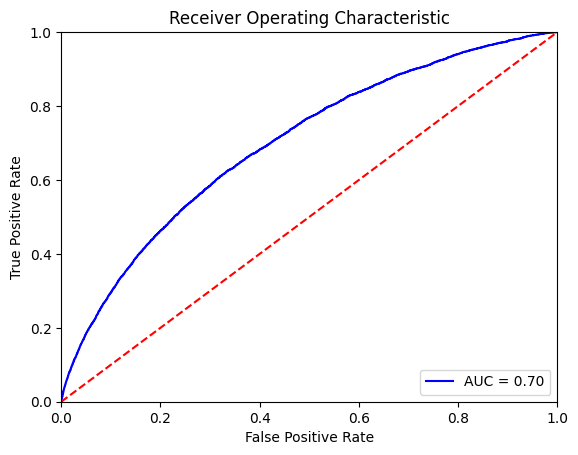

In [49]:
logis_smote = LogisticRegression()
logis_smote.fit(X_smote, y_smote)

reglog_under_smote = logis_smote.predict(X_val_stand)

model_eval(logis_smote, X_val_stand, y_val)


### Dummy Classifier


2025/01/06 19:24:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '31e8e4e5f7744026928d4e9fbb9f3408', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[35188 35417]
 [ 3189  3084]]
Accuracy score    : 0.498
precision score   : 0.0801
recall score      : 0.492
F1 score          : 0.138
F2 score          : 0.24
ROCAUC score      : 0.495
custom metric FMI : 0.198



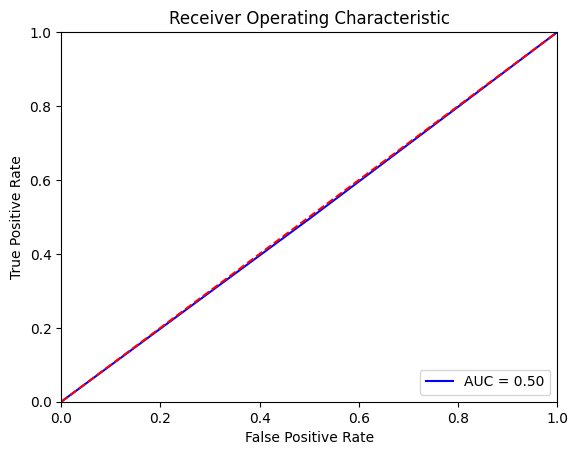

In [50]:
dummy_smote = DummyClassifier(strategy="stratified")
dummy_smote.fit(X_smote, y_smote)

dummy_under_smote = dummy_smote.predict(X_val_stand)

model_eval(dummy_smote, X_val_stand, y_val)

### Random Forest


2025/01/06 19:24:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '03068013c33d4666afb8d8160d525bd0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[70302   303]
 [ 6117   156]]
Accuracy score    : 0.916
precision score   : 0.34
recall score      : 0.0249
F1 score          : 0.0463
F2 score          : 0.031
ROCAUC score      : 0.51
custom metric FMI : 0.0919



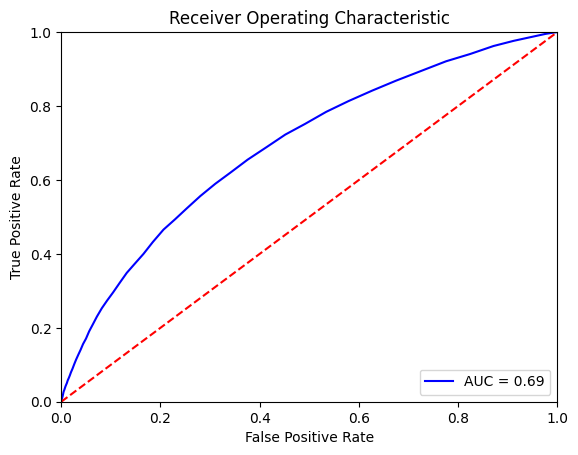

In [51]:
random_smote = RandomForestClassifier()
random_smote.fit(X_smote, y_smote)

random_under_smote = random_smote.predict(X_val_stand)

model_eval(random_smote, X_val_stand, y_val)

### XGBoost


[[70450   155]
 [ 6155   118]]
Accuracy score    : 0.918
precision score   : 0.432
recall score      : 0.0188
F1 score          : 0.0361
F2 score          : 0.023
ROCAUC score      : 0.508
custom metric FMI : 0.0902



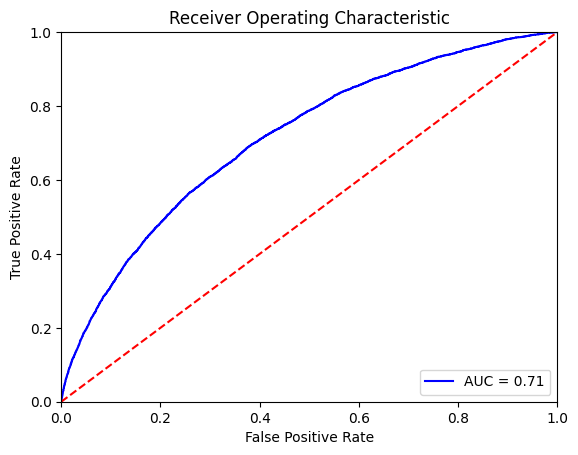

In [52]:

xgboost_smote = xgb.XGBClassifier()
xgboost_smote.fit(X_smote, y_smote)

xgboost_under_smote = xgboost_smote.predict(X_val_stand)

model_eval(xgboost_smote, X_val_stand, y_val)

### LIGHTGBM


[LightGBM] [Info] Number of positive: 212081, number of negative: 212081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5863
[LightGBM] [Info] Number of data points in the train set: 424162, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[70544    61]
 [ 6222    51]]
Accuracy score    : 0.918
precision score   : 0.455
recall score      : 0.00813
F1 score          : 0.016
F2 score          : 0.01
ROCAUC score      : 0.504
custom metric FMI : 0.0608



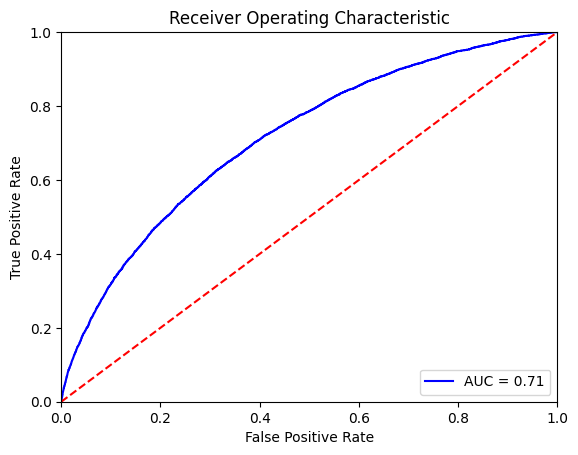

In [53]:
light_smote = LGBMClassifier()
light_smote.fit(X_smote, y_smote)

light_under_smote = light_smote.predict(X_val_stand)

model_eval(light_smote, X_val_stand, y_val)

# Modele retenu optimisation des hyperparametres

## Choix des hyperparametres logisticRegression

In [54]:
cross_val_score(LogisticRegression(), X_under, y_under, cv = 10).mean()


2025/01/06 19:30:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b213d63920544035834a5ea69447d6b1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:30:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a654d5e12b864e43966b45db76607f45', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:31:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '16681f70d6f74f679daa39ac90720fc8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:31:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a407748aef8743e78b9a4c748dea382e', which will track hyperparameters, performance metrics, model artifacts, and lineage i

0.6404702418176893

In [55]:
C = [1,10,100,1000, 10000, 100000]
score_apprentissage, score_validation = validation_curve(logis_under, X_under, y_under,
                                                        param_name = 'C',
                                                        param_range = C, cv = 10)

2025/01/06 19:31:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'db49718528164291ae565b185cd22233', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:32:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f3ae7835a9444b3b82061e40ed525aaf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:32:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9163e816292048d59730485d8dce66e6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:32:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '82c60f1b5274463fa122e698ef76ca33', which will track hyperparameters, performance metrics, model artifacts, and lineage i

In [56]:
score_validation.mean(axis = 1)


array([0.64047024, 0.64047024, 0.64047024, 0.64047024, 0.64047024,
       0.64047024])

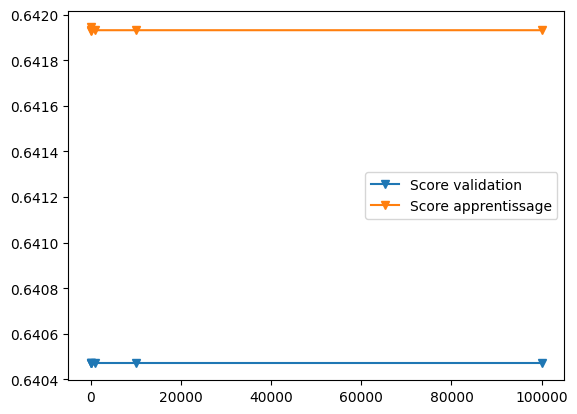

In [57]:
plt.plot(C, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(C, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

In [58]:
grid_param = {'C' : [0, 5000, 10000]}

grid_search_rl = GridSearchCV(LogisticRegression(), grid_param, cv = 5)

In [59]:
# ici, on entraine la fonction
grid_search_rl.fit(X_under, y_under)

2025/01/06 19:39:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2bfd375793854145b69c89f96665a261', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/06 19:39:17 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0, 5000, 10000]})

In [60]:
# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid_search_rl.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid_search_rl.best_params_)

Le meilleur score avec les hyperparamètres est de :  0.6405240718860407
Les meilleurs hyperparamètres sont :  {'C': 5000}


## Choix des hyperparametres XGBoost

In [61]:
import sklearn
import xgboost as xgb

print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgb.__version__)


Scikit-learn version: 1.5.2
XGBoost version: 2.1.3


In [62]:
%%time


max_depth = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
score_apprentissage, score_validation = validation_curve(xgboost_under, X_under, y_under,
                                                          param_name='max_depth',
                                                          param_range=max_depth, cv=10)

CPU times: user 13min 41s, sys: 11.8 s, total: 13min 53s
Wall time: 8min 36s


In [63]:
score_validation.mean(axis = 1)


array([0.66292072, 0.66168068, 0.64817805, 0.63941941, 0.63917693,
       0.63871854, 0.63966216, 0.64273405, 0.64157558, 0.64610315])

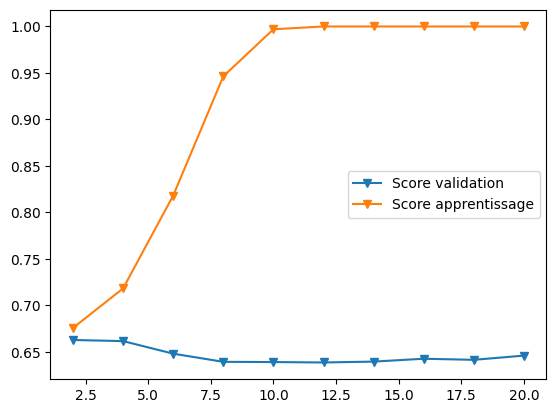

In [64]:
plt.plot(max_depth, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(max_depth, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

In [65]:
%%time

learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
score_apprentissage, score_validation = validation_curve(xgboost_under, X_under, y_under,
                                                          param_name='learning_rate',
                                                          param_range=learning_rate, cv=10)

CPU times: user 2min 28s, sys: 531 ms, total: 2min 29s
Wall time: 1min 32s


In [66]:
score_validation.mean(axis = 1)


array([0.64771983, 0.66246245, 0.66367554, 0.65313749, 0.63499903,
       0.61618689, 0.60977259])

In [67]:
grid_param = {'max_depth': [2, 3, 4],
             'learning_rate': [0.1, 0.15]}

grid_search_xg = GridSearchCV(xgb.XGBClassifier(), grid_param, cv = 5, verbose = 5)

In [68]:

%%time

# ici, on entraine la fonction
grid_search_xg.fit(X_train_stand, y_train)

2025/01/06 19:49:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b4e25b59c4934685bdb775d3e6f3222b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....learning_rate=0.1, max_depth=2;, score=0.920 total time=   1.8s
[CV 2/5] END ....learning_rate=0.1, max_depth=2;, score=0.920 total time=   1.6s
[CV 3/5] END ....learning_rate=0.1, max_depth=2;, score=0.920 total time=   1.7s
[CV 4/5] END ....learning_rate=0.1, max_depth=2;, score=0.920 total time=   1.8s
[CV 5/5] END ....learning_rate=0.1, max_depth=2;, score=0.920 total time=   1.7s
[CV 1/5] END ....learning_rate=0.1, max_depth=3;, score=0.920 total time=   6.7s
[CV 2/5] END ....learning_rate=0.1, max_depth=3;, score=0.920 total time=   7.2s
[CV 3/5] END ....learning_rate=0.1, max_depth=3;, score=0.920 total time=  11.6s
[CV 4/5] END ....learning_rate=0.1, max_depth=3;, score=0.920 total time=   7.1s
[CV 5/5] END ....learning_rate=0.1, max_depth=3;, score=0.920 total time=  13.2s
[CV 1/5] END ....learning_rate=0.1, max_depth=4;, score=0.920 total time=  11.1s
[CV 2/5] END ....learning_rate=0.1, max_depth=4;,

2025/01/06 19:53:50 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


CPU times: user 3min 17s, sys: 4.2 s, total: 3min 21s
Wall time: 4min 25s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.15], 'max_depth': [2, 3, 4]},
             verbose=5)

In [69]:

# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid_search_xg.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid_search_xg.best_params_)

Le meilleur score avec les hyperparamètres est de :  0.9195908649436507
Les meilleurs hyperparamètres sont :  {'learning_rate': 0.1, 'max_depth': 3}


## Choix des hyperparametres LightGBM

In [70]:
cross_val_score(LGBMClassifier(), X_under, y_under, cv = 10).mean()


[LightGBM] [Info] Number of positive: 16697, number of negative: 16696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 33393, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000060
[LightGBM] [Info] Start training from score 0.000060
[LightGBM] [Info] Number of positive: 16697, number of negative: 16696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 33393, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000060
[Ligh

0.6627589500436162

In [71]:

max_depth = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
score_apprentissage, score_validation = validation_curve(light_under, X_under, y_under,
                                                          param_name='max_depth',
                                                          param_range=max_depth, cv=10)

[LightGBM] [Info] Number of positive: 16697, number of negative: 16696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 33393, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000060
[LightGBM] [Info] Start training from score 0.000060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [72]:
score_validation.mean(axis = 1)


array([0.6555362 , 0.66531942, 0.66491514, 0.66445677, 0.66356762,
       0.6648074 , 0.6639178 , 0.66259725, 0.66275895, 0.66275895])

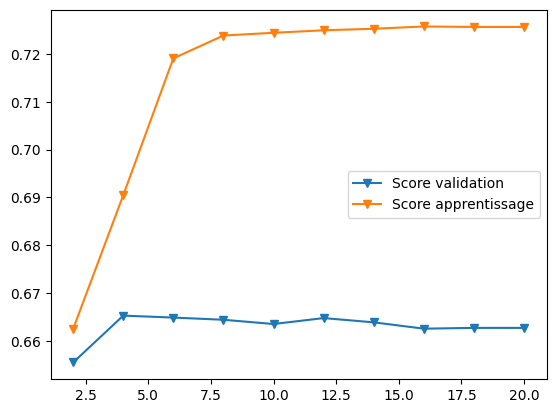

In [73]:
plt.plot(max_depth, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(max_depth, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

In [74]:
%%time

learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
score_apprentissage, score_validation = validation_curve(light_under, X_under, y_under,
                                                          param_name='learning_rate',
                                                          param_range=learning_rate, cv=10)

[LightGBM] [Info] Number of positive: 16697, number of negative: 16696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 33393, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000060
[LightGBM] [Info] Start training from score 0.000060
[LightGBM] [Info] Number of positive: 16697, number of negative: 16696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 33393, number of used features: 23
[LightGBM] [Info] [b

In [75]:
score_validation.mean(axis = 1)


array([0.64715388, 0.66302848, 0.66275895, 0.65529354, 0.63437948,
       0.61820811, 0.60823671])

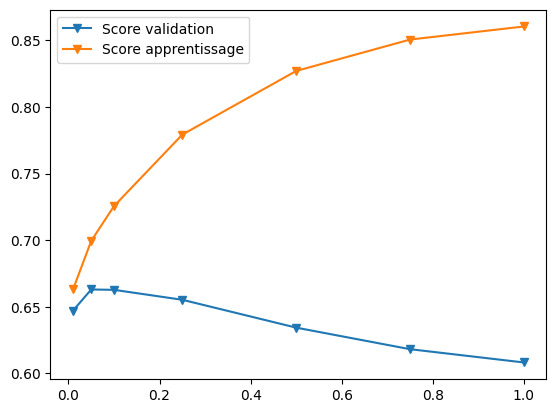

In [76]:
plt.plot(learning_rate, score_validation.mean(axis = 1), marker = 'v', label = 'Score validation')
plt.plot(learning_rate, score_apprentissage.mean(axis = 1), marker = 'v', label = 'Score apprentissage')
plt.legend()

In [77]:

%%time

grid_param = {'max_depth': [8, 10,12, 14, 16, 18],
             'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}

grid_search_light = GridSearchCV(LGBMClassifier(), grid_param, cv = 5, verbose = 5)


CPU times: user 75 µs, sys: 0 ns, total: 75 µs
Wall time: 79.9 µs


In [78]:
%%time

# ici, on entraine la fonction
grid_search_light.fit(X_under, y_under)

2025/01/06 19:58:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '71531347e9f046ab809893b5ce39a31d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 14842, number of negative: 14841
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3202
[LightGBM] [Info] Number of data points in the train set: 29683, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500017 -> initscore=0.000067
[LightGBM] [Info] Start training from score 0.000067
[CV 1/5] END ....learning_rate=0.1, max_depth=8;, score=0.663 total time=   1.4s
[LightGBM] [Info] Number of positive: 14842, number of negative: 14841
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

2025/01/06 20:01:55 INFO mlflow.sklearn.utils: Logging the 5 best runs, 25 runs will be omitted.


CPU times: user 2min 24s, sys: 2.78 s, total: 2min 27s
Wall time: 3min 32s


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_depth': [8, 10, 12, 14, 16, 18]},
             verbose=5)

In [79]:
# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid_search_light.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid_search_light.best_params_)

Le meilleur score avec les hyperparamètres est de :  0.6622199404254918
Les meilleurs hyperparamètres sont :  {'learning_rate': 0.1, 'max_depth': 16}


# Entrainement des modèles

In [80]:
# Création des déséquilibres Undersampling des données

under = RandomUnderSampler(random_state=12)

# fit and apply the transform
X_under, y_under = under.fit_resample(X_train_stand, y_train)

print(Counter(y_train))
print(Counter(y_under))

Counter({0: 212081, 1: 18552})
Counter({0: 18552, 1: 18552})


## LightGBM

[LightGBM] [Info] Number of positive: 18552, number of negative: 18552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3207
[LightGBM] [Info] Number of data points in the train set: 37104, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[47308 23297]
 [ 2167  4106]]
Accuracy score    : 0.669
precision score   : 0.15
recall score      : 0.655
F1 score          : 0.244
F2 score          : 0.39
ROCAUC score      : 0.662
custom metric FMI : 0.313



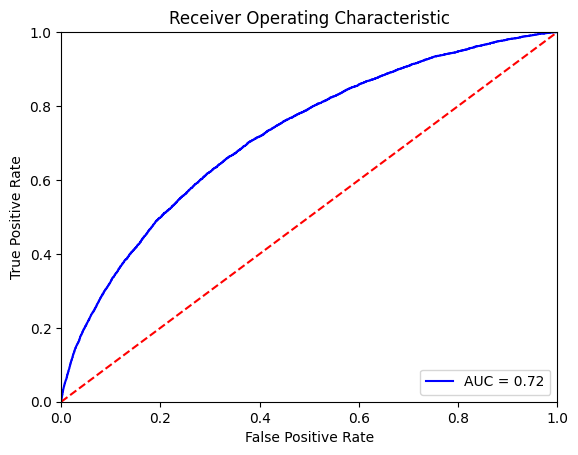

In [81]:
# Entrainement avec nos meilleurs paramètres
params = {'learning_rate': 0.1,
          'max_depth': 16}


lightgbm = LGBMClassifier(**params)

# Entrainement avec LIGHTGBM
model = lightgbm.fit(X_under, y_under)

y_pred_rus = lightgbm.predict(X_val_stand)

model_eval(lightgbm, X_val_stand, y_val)

## XGBOOST

[[46877 23728]
 [ 2116  4157]]
Accuracy score    : 0.664
precision score   : 0.149
recall score      : 0.663
F1 score          : 0.243
F2 score          : 0.39
ROCAUC score      : 0.663
custom metric FMI : 0.314



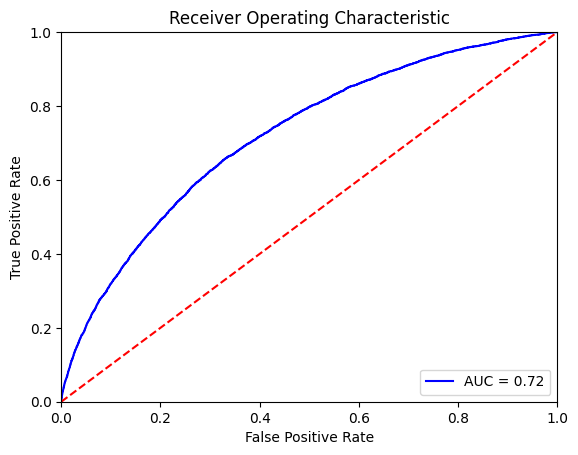

In [88]:
# Entrainement avec nos meilleurs paramètres
param_xgboost = {'learning_rate': 0.1,
          'max_depth': 3}

xgboost =xgb.XGBClassifier(**param_xgboost)

# Entrainement avec LIGHTGBM
model2 = xgboost.fit(X_under, y_under)

y_pred_rus = xgboost.predict(X_val_stand)

model_eval(xgboost, X_val_stand, y_val)

## régression logistique

2025/01/06 20:16:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6bde2705373f4a168ddd93d2e60ec85b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[[46386 24219]
 [ 2328  3945]]
Accuracy score    : 0.655
precision score   : 0.14
recall score      : 0.629
F1 score          : 0.229
F2 score          : 0.37
ROCAUC score      : 0.643
custom metric FMI : 0.297



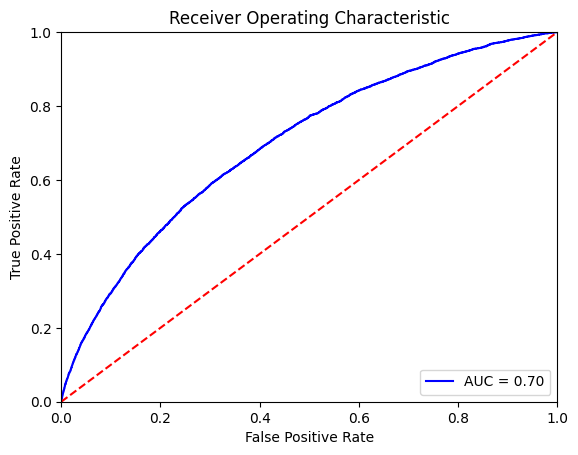

In [90]:
# Entrainement avec nos meilleurs paramètres
param_log = {'C': 5000,
          'random_state': 12}

reg_log = LogisticRegression(**param_log)

# Entrainement avec LIGHTGBM
model3 = reg_log.fit(X_under, y_under)

y_pred_rus = reg_log.predict(X_val_stand)

model_eval(reg_log, X_val_stand, y_val)

# Enregistrement du modèle

In [87]:
import pickle
save_path = '/content/drive/My Drive/Projets Master/Projet 7/model_streamlit.pkl'
# Sauvegarde du modèle
with open(save_path, 'wb') as file:
    pickle.dump(model, file)
print(f"Le modèle a été sauvegardé dans : {save_path}")


Le modèle a été sauvegardé dans : /content/drive/My Drive/Projets Master/Projet 7/model_streamlit.pkl


[2025-01-06 20:02:23 +0000] [92639] [INFO] Starting gunicorn 23.0.0
[2025-01-06 20:02:23 +0000] [92639] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-01-06 20:02:23 +0000] [92639] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-01-06 20:02:24 +0000] [92639] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-01-06 20:02:24 +0000] [92639] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-01-06 20:02:25 +0000] [92639] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-01-06 20:02:25 +0000] [92639] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-01-06 20:02:26 +0000] [92639] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-01-06 20:02:26 +0000] [92639] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 98] Address already in use
[2025-01-06 20:02:27 +0000] [92639] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2025-01-06 20:02:27 +0000] [92639] [

In [91]:
ngrok.kill()

In [95]:
ngrok.kill()